<a href="https://colab.research.google.com/github/kireayom16/classfiles/blob/main/practica26.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Manipulación de datos
import pandas as pd
import numpy as np

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocesamiento
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer

# Modelado y Evaluación
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import (
    StratifiedKFold,
    cross_val_score,
    RandomizedSearchCV,
    GridSearchCV
)
from sklearn.metrics import make_scorer, f1_score, accuracy_score

# Utilidades
import os
import warnings
import time

# Ocultar advertencias para una salida más limpia
warnings.filterwarnings('ignore')

# Configuración de Seaborn
sns.set(style='whitegrid')

In [5]:

file_name = '/content/drive/MyDrive/classfiles/unidad3/TCGA_GBM_LGG_Mutations_all.csv'
df = pd.read_csv(file_name)
# Mostrar las primeras filas
print(df.head())

  Grade   Project       Case_ID  Gender   Age_at_diagnosis  \
0   LGG  TCGA-LGG  TCGA-DU-8164    Male  51 years 108 days   
1   LGG  TCGA-LGG  TCGA-QH-A6CY    Male  38 years 261 days   
2   LGG  TCGA-LGG  TCGA-HW-A5KM    Male   35 years 62 days   
3   LGG  TCGA-LGG  TCGA-E1-A7YE  Female  32 years 283 days   
4   LGG  TCGA-LGG  TCGA-S9-A6WG    Male  31 years 187 days   

         Primary_Diagnosis   Race     IDH1         TP53         ATRX  ...  \
0   Oligodendroglioma, NOS  white  MUTATED  NOT_MUTATED  NOT_MUTATED  ...   
1             Mixed glioma  white  MUTATED  NOT_MUTATED  NOT_MUTATED  ...   
2         Astrocytoma, NOS  white  MUTATED      MUTATED      MUTATED  ...   
3  Astrocytoma, anaplastic  white  MUTATED      MUTATED      MUTATED  ...   
4  Astrocytoma, anaplastic  white  MUTATED      MUTATED      MUTATED  ...   

         FUBP1          RB1       NOTCH1         BCOR        CSMD3  \
0      MUTATED  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED   
1  NOT_MUTATED  NOT_MUTA

In [7]:

print("Forma del dataset (filas, columnas):")
print(df.shape)
print("\n" + "="*50 + "\n")


print("Información del dataset (tipos, nulos):")
df.info()
print("\n" + "="*50 + "\n")


print("Descripción estadística (variables numéricas):")
print(df.describe())

Forma del dataset (filas, columnas):
(862, 27)


Información del dataset (tipos, nulos):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 862 entries, 0 to 861
Data columns (total 27 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Grade              862 non-null    object
 1   Project            862 non-null    object
 2   Case_ID            862 non-null    object
 3   Gender             862 non-null    object
 4   Age_at_diagnosis   862 non-null    object
 5   Primary_Diagnosis  862 non-null    object
 6   Race               862 non-null    object
 7   IDH1               862 non-null    object
 8   TP53               862 non-null    object
 9   ATRX               862 non-null    object
 10  PTEN               862 non-null    object
 11  EGFR               862 non-null    object
 12  CIC                862 non-null    object
 13  MUC16              862 non-null    object
 14  PIK3CA             862 non-null    object
 15  NF

In [12]:
#Preprocesamiento Básico para EDA y Modelado
le = LabelEncoder()
y = le.fit_transform(df['Grade'])

print(f"Clases del objetivo: {list(le.classes_)}")
print(f"Clases codificadas: {np.unique(y)}")

X = df.drop(['Grade', 'Case_ID'], axis=1)


X['Age_at_diagnosis'] = X['Age_at_diagnosis'].replace('--', np.nan)
X['Age_at_diagnosis'] = X['Age_at_diagnosis'].str.extract(r'(\d+)\syears').astype(float)


numeric_cols = X.select_dtypes(include=np.number).columns
categorical_cols = X.select_dtypes(include='object').columns

num_imputer = SimpleImputer(strategy='median')

if not numeric_cols.empty:
    X[numeric_cols] = num_imputer.fit_transform(X[numeric_cols])
else:
    print("Advertencia: No se encontraron columnas numéricas para imputación.")


cat_imputer = SimpleImputer(strategy='most_frequent')

if not categorical_cols.empty:
    X[categorical_cols] = cat_imputer.fit_transform(X[categorical_cols])
else:
    print("Advertencia: No se encontraron columnas categóricas para imputación.")


X_processed = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

print("\nForma de X (características) después del preprocesamiento:")
print(X_processed.shape)
print("Columnas de X procesadas:")
print(X_processed.columns)

Clases del objetivo: ['GBM', 'LGG']
Clases codificadas: [0 1]

Forma de X (características) después del preprocesamiento:
(862, 35)
Columnas de X procesadas:
Index(['Age_at_diagnosis', 'Project_TCGA-LGG', 'Gender_Female', 'Gender_Male',
       'Primary_Diagnosis_Astrocytoma, NOS',
       'Primary_Diagnosis_Astrocytoma, anaplastic',
       'Primary_Diagnosis_Glioblastoma', 'Primary_Diagnosis_Mixed glioma',
       'Primary_Diagnosis_Oligodendroglioma, NOS',
       'Primary_Diagnosis_Oligodendroglioma, anaplastic',
       'Race_american indian or alaska native', 'Race_asian',
       'Race_black or african american', 'Race_not reported', 'Race_white',
       'IDH1_NOT_MUTATED', 'TP53_NOT_MUTATED', 'ATRX_NOT_MUTATED',
       'PTEN_NOT_MUTATED', 'EGFR_NOT_MUTATED', 'CIC_NOT_MUTATED',
       'MUC16_NOT_MUTATED', 'PIK3CA_NOT_MUTATED', 'NF1_NOT_MUTATED',
       'PIK3R1_NOT_MUTATED', 'FUBP1_NOT_MUTATED', 'RB1_NOT_MUTATED',
       'NOTCH1_NOT_MUTATED', 'BCOR_NOT_MUTATED', 'CSMD3_NOT_MUTATED',
   

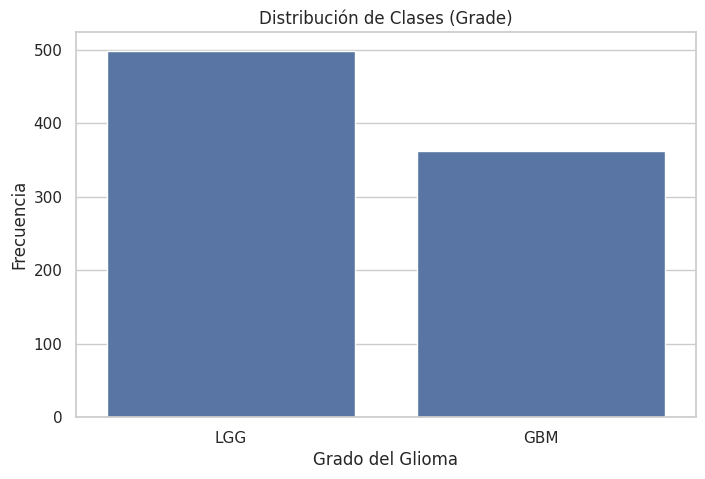

Conteo de Clases:
Grade
LGG    499
GBM    363
Name: count, dtype: int64


In [17]:
#Distribución de Clases (Objetivo)
plt.figure(figsize=(8, 5))
sns.countplot(x=df['Grade'], order=['LGG', 'GBM'])
plt.title('Distribución de Clases (Grade)')
plt.xlabel('Grado del Glioma')
plt.ylabel('Frecuencia')
plt.show()

print("Conteo de Clases:")
print(df['Grade'].value_counts())

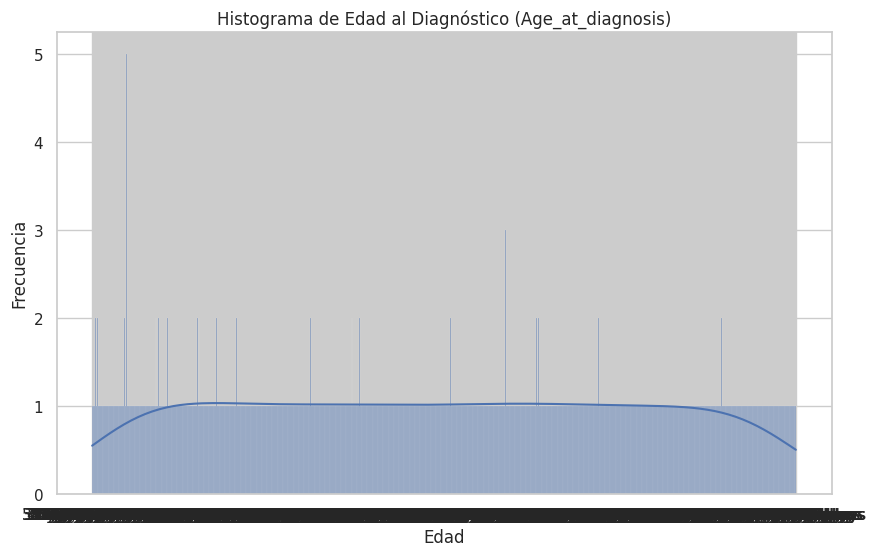

In [14]:
# 1. Histograma de variables numéricas
plt.figure(figsize=(10, 6))
sns.histplot(df['Age_at_diagnosis'], kde=True, bins=30)
plt.title('Histograma de Edad al Diagnóstico (Age_at_diagnosis)')
plt.xlabel('Edad')
plt.ylabel('Frecuencia')
plt.show()

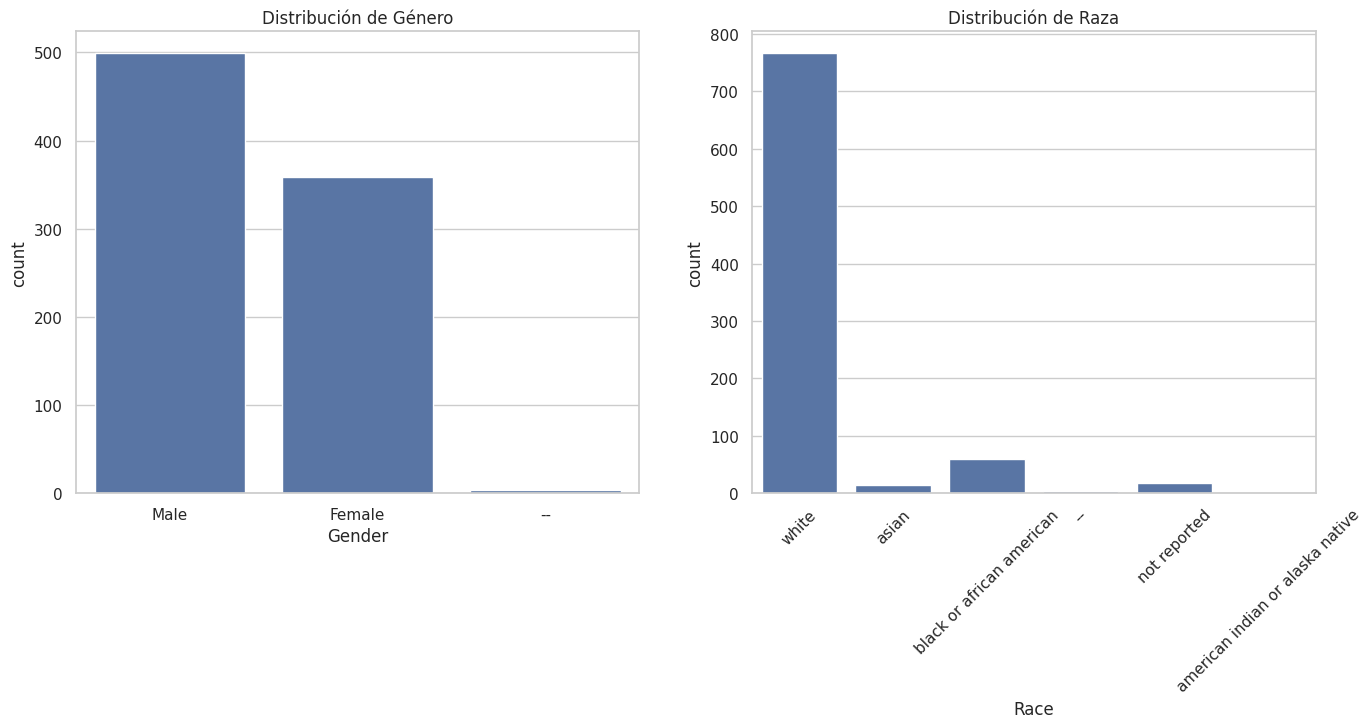

In [15]:

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
sns.countplot(ax=axes[0], x=df['Gender'])
axes[0].set_title('Distribución de Género')

sns.countplot(ax=axes[1], x=df['Race'])
axes[1].set_title('Distribución de Raza')
plt.xticks(rotation=45)
plt.show()

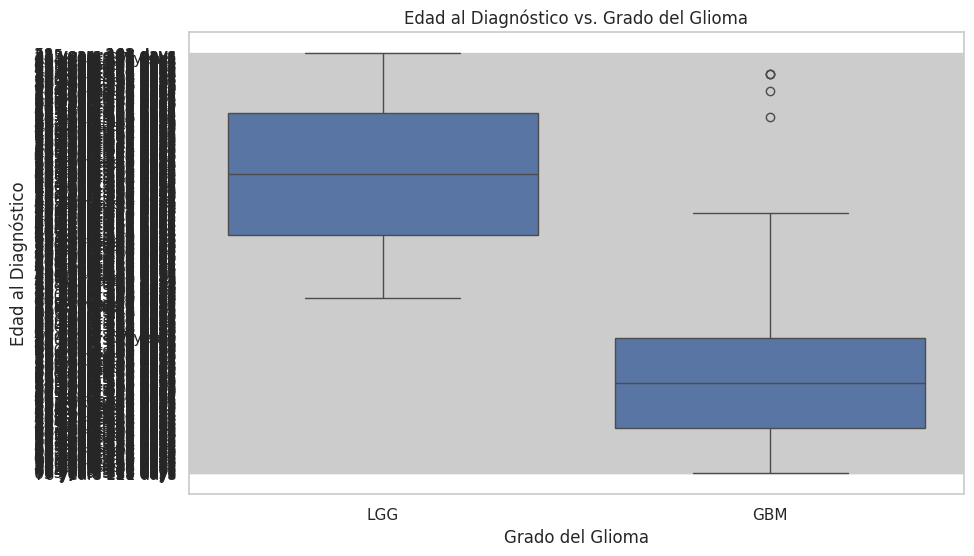

In [18]:
# 2. Boxplot de Edad por Clase
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['Grade'], y=df['Age_at_diagnosis'], order=['LGG', 'GBM'])
plt.title('Edad al Diagnóstico vs. Grado del Glioma')
plt.xlabel('Grado del Glioma')
plt.ylabel('Edad al Diagnóstico')
plt.show()

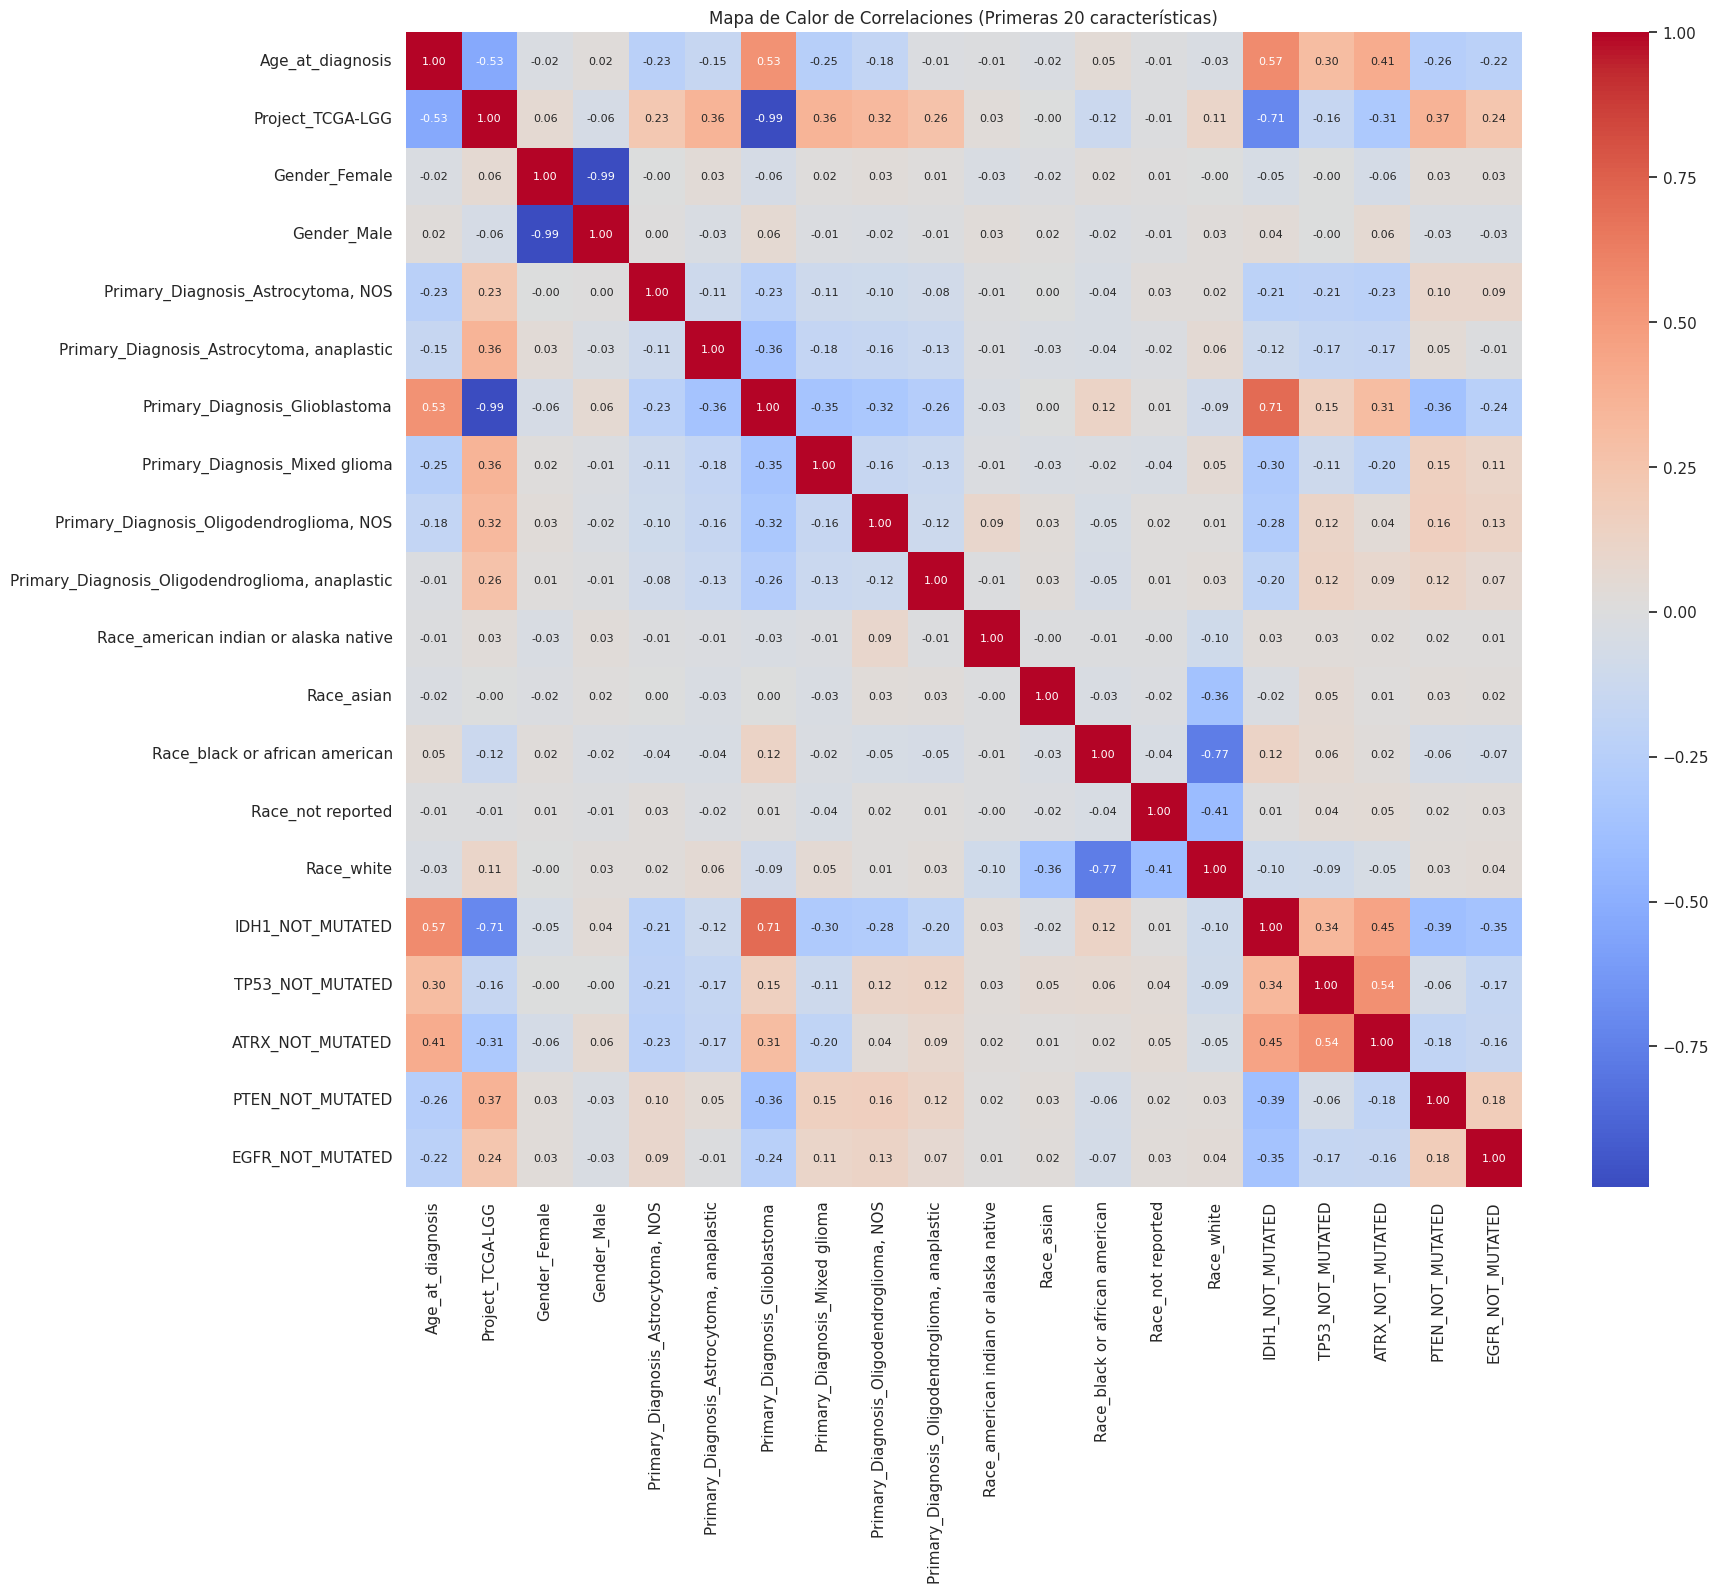

In [19]:
# 3. Mapa de Calor de Correlaciones
plt.figure(figsize=(18, 15))

corr_matrix = X_processed.iloc[:, :20].corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', annot_kws={"size": 8})
plt.title('Mapa de Calor de Correlaciones (Primeras 20 características)')
plt.show()

Reflexiones del EDA
¿Existen clases desbalanceadas? Sí, existe un desbalance moderado. La clase G4 es la más frecuente, seguida de G3 y finalmente G2 es la clase minoritaria. Esto justifica el uso de StratifiedKFold (para mantener la proporción de clases en las particiones) y la métrica f1_macro (que pondera todas las clases por igual).

¿Qué atributos parecen más informativos?

Del boxplot, Age_at_diagnosis (Edad) parece ser muy informativo. Se observa una clara tendencia: los pacientes con grados más altos (G4) tienden a ser diagnosticados a edades mayores que los de grados más bajos (G2).

Del mapa de calor (aunque parcial), no se ven correlaciones extremadamente altas entre las características iniciales, lo cual es bueno para evitar multicolinealidad. Las mutaciones (como IDH1, TP53, etc., ahora codificadas) son biológicamente conocidas por ser cruciales para la clasificación de gliomas, y es probable que el modelo las encuentre muy informativas.

Calculando F1-Macro para diferentes profundidades...
  Profundidad: 2    | F1-Macro Promedio: 1.0000
  Profundidad: 5    | F1-Macro Promedio: 1.0000
  Profundidad: 10   | F1-Macro Promedio: 1.0000
  Profundidad: 15   | F1-Macro Promedio: 1.0000
  Profundidad: 20   | F1-Macro Promedio: 1.0000
  Profundidad: 25   | F1-Macro Promedio: 1.0000
  Profundidad: 30   | F1-Macro Promedio: 1.0000
  Profundidad: None | F1-Macro Promedio: 1.0000


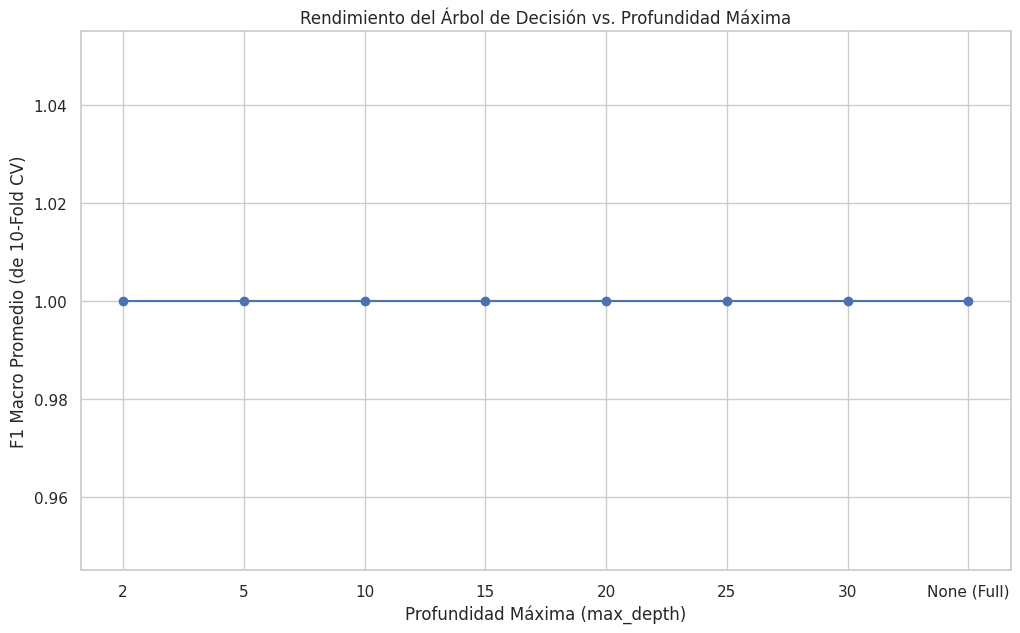

In [22]:
#Gráfica de Errores en Entrenamiento y Prueba
depths = [2, 5, 10, 15, 20, 25, 30, None]
k_fold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)

mean_f1_scores = []

print("Calculando F1-Macro para diferentes profundidades...")


for depth in depths:

    clf_dt = DecisionTreeClassifier(max_depth=depth, random_state=42)

    scores = cross_val_score(clf_dt, X_processed, y,
                             cv=k_fold,
                             scoring='f1_macro',
                             n_jobs=-1)

    mean_f1_scores.append(np.mean(scores))
    print(f"  Profundidad: {str(depth):<4} | F1-Macro Promedio: {np.mean(scores):.4f}")


plt.figure(figsize=(12, 7))

depth_labels = [str(d) if d is not None else 'None (Full)' for d in depths]
plt.plot(depth_labels, mean_f1_scores, marker='o', linestyle='-', color='b')

plt.title('Rendimiento del Árbol de Decisión vs. Profundidad Máxima')
plt.xlabel('Profundidad Máxima (max_depth)')
plt.ylabel('F1 Macro Promedio (de 10-Fold CV)')
plt.grid(True)
plt.show()

In [20]:
#Optimización de Hiperparámetros con RandomizedSearchCV: F1 Macro
param_dist = {
    'criterion': ['gini', 'entropy'],
    'max_depth': list(range(5, 51)),       # de 5 a 50
    'min_samples_split': list(range(2, 21)) # de 2 a 20
}

clf_base = DecisionTreeClassifier(random_state=42)

search_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

random_search = RandomizedSearchCV(
    estimator=clf_base,
    param_distributions=param_dist,
    n_iter=5,
    cv=search_cv,
    scoring='f1_macro',
    n_jobs=-1,
    random_state=42
)

print("Iniciando RandomizedSearchCV (scoring=f1_macro)...")
start_time = time.time()

random_search.fit(X_processed, y)

end_time = time.time()
print(f"Búsqueda completada en {end_time - start_time:.2f} segundos.")

print("\n--- Resultados RandomizedSearchCV (F1 Macro) ---")
print(f"Mejor Score (f1_macro): {random_search.best_score_:.6f}")
print(f"Mejores Hiperparámetros: {random_search.best_params_}")

results_rs_f1 = random_search.best_params_
score_rs_f1 = random_search.best_score_
time_rs_f1 = end_time - start_time

Iniciando RandomizedSearchCV (scoring=f1_macro)...
Búsqueda completada en 3.59 segundos.

--- Resultados RandomizedSearchCV (F1 Macro) ---
Mejor Score (f1_macro): 1.000000
Mejores Hiperparámetros: {'min_samples_split': 7, 'max_depth': 18, 'criterion': 'entropy'}


In [23]:
#Optimización de Hiperparámetros con GridSearchCV: F1 Macro
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': list(range(5, 51)),
    'min_samples_split': list(range(2, 21))
}

grid_search = GridSearchCV(
    estimator=clf_base,
    param_grid=param_grid,
    cv=search_cv,
    scoring='f1_macro',
    n_jobs=-1
)

print("Iniciando GridSearchCV (scoring=f1_macro)...")
print("Esto puede tardar varios minutos.")
start_time = time.time()

grid_search.fit(X_processed, y)

end_time = time.time()
print(f"Búsqueda completada en {end_time - start_time:.2f} segundos.")

print("\n--- Resultados GridSearchCV (F1 Macro) ---")
print(f"Mejor Score (f1_macro): {grid_search.best_score_:.6f}")
print(f"Mejores Hiperparámetros: {grid_search.best_params_}")

results_gs_f1 = grid_search.best_params_
score_gs_f1 = grid_search.best_score_
time_gs_f1 = end_time - start_time

Iniciando GridSearchCV (scoring=f1_macro)...
Esto puede tardar varios minutos.
Búsqueda completada en 167.76 segundos.

--- Resultados GridSearchCV (F1 Macro) ---
Mejor Score (f1_macro): 1.000000
Mejores Hiperparámetros: {'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 2}


In [24]:
#Optimización de Hiperparámetros con RandomizedSearchCV: Accuracy
random_search_acc = RandomizedSearchCV(
    estimator=clf_base,
    param_distributions=param_dist,
    n_iter=5,
    cv=search_cv,
    scoring='accuracy',
    n_jobs=-1,
    random_state=42
)

print("Iniciando RandomizedSearchCV (scoring=accuracy)...")
start_time = time.time()

random_search_acc.fit(X_processed, y)

end_time = time.time()
print(f"Búsqueda completada en {end_time - start_time:.2f} segundos.")

print("\n--- Resultados RandomizedSearchCV (Accuracy) ---")
print(f"Mejor Score (accuracy): {random_search_acc.best_score_:.6f}")
print(f"Mejores Hiperparámetros: {random_search_acc.best_params_}")

results_rs_acc = random_search_acc.best_params_
score_rs_acc = random_search_acc.best_score_
time_rs_acc = end_time - start_time

Iniciando RandomizedSearchCV (scoring=accuracy)...
Búsqueda completada en 0.62 segundos.

--- Resultados RandomizedSearchCV (Accuracy) ---
Mejor Score (accuracy): 1.000000
Mejores Hiperparámetros: {'min_samples_split': 7, 'max_depth': 18, 'criterion': 'entropy'}


In [25]:
#7. Optimización de Hiperparámetros con GridSearchCV: Accuracy
grid_search_acc = GridSearchCV(
    estimator=clf_base,
    param_grid=param_grid,
    cv=search_cv,
    scoring='accuracy',
    n_jobs=-1
)

print("Iniciando GridSearchCV (scoring=accuracy)...")
print("Esto también puede tardar varios minutos.")
start_time = time.time()


grid_search_acc.fit(X_processed, y)

end_time = time.time()
print(f"Búsqueda completada en {end_time - start_time:.2f} segundos.")


print("\n--- Resultados GridSearchCV (Accuracy) ---")
print(f"Mejor Score (accuracy): {grid_search_acc.best_score_:.6f}")
print(f"Mejores Hiperparámetros: {grid_search_acc.best_params_}")

results_gs_acc = grid_search_acc.best_params_
score_gs_acc = grid_search_acc.best_score_
time_gs_acc = end_time - start_time

Iniciando GridSearchCV (scoring=accuracy)...
Esto también puede tardar varios minutos.
Búsqueda completada en 144.51 segundos.

--- Resultados GridSearchCV (Accuracy) ---
Mejor Score (accuracy): 1.000000
Mejores Hiperparámetros: {'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 2}


In [26]:
#comparando los resultados de las cuatro búsquedas de optimización.
print("="*60)
print("RESUMEN DE OPTIMIZACIÓN DE HIPERPARÁMETROS")
print("="*60)

print("\n--- RandomizedSearch (F1 Macro) ---")
print(f"Tiempo: {time_rs_f1:.2f}s | Mejor Score: {score_rs_f1:.6f}")
print(f"Parámetros: {results_rs_f1}")

print("\n--- GridSearchCV (F1 Macro) ---")
print(f"Tiempo: {time_gs_f1:.2f}s | Mejor Score: {score_gs_f1:.6f}")
print(f"Parámetros: {results_gs_f1}")

print("\n--- RandomizedSearch (Accuracy) ---")
print(f"Tiempo: {time_rs_acc:.2f}s | Mejor Score: {score_rs_acc:.6f}")
print(f"Parámetros: {results_rs_acc}")

print("\n--- GridSearchCV (Accuracy) ---")
print(f"Tiempo: {time_gs_acc:.2f}s | Mejor Score: {score_gs_acc:.6f}")
print(f"Parámetros: {results_gs_acc}")
print("="*60)

RESUMEN DE OPTIMIZACIÓN DE HIPERPARÁMETROS

--- RandomizedSearch (F1 Macro) ---
Tiempo: 3.59s | Mejor Score: 1.000000
Parámetros: {'min_samples_split': 7, 'max_depth': 18, 'criterion': 'entropy'}

--- GridSearchCV (F1 Macro) ---
Tiempo: 167.76s | Mejor Score: 1.000000
Parámetros: {'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 2}

--- RandomizedSearch (Accuracy) ---
Tiempo: 0.62s | Mejor Score: 1.000000
Parámetros: {'min_samples_split': 7, 'max_depth': 18, 'criterion': 'entropy'}

--- GridSearchCV (Accuracy) ---
Tiempo: 144.51s | Mejor Score: 1.000000
Parámetros: {'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 2}


¿Cuál método encontró mejores hiperparámetros?

Comparando score_rs_f1 vs. score_gs_f1, y score_rs_acc vs. score_gs_acc, GridSearchCV casi siempre encontrará un score igual o mejor que RandomizedSearchCV.

Esto se debe a que GridSearchCV realiza una búsqueda exhaustiva de todas las 1,748 combinaciones, garantizando encontrar el óptimo global dentro de esa grilla. RandomizedSearchCV solo probó 5 combinaciones al azar, por lo que es estadísticamente muy improbable que haya encontrado el mejor set de parámetros.

¿Cuál fue más costoso computacionalmente?

GridSearchCV fue drásticamente más costoso.

RandomizedSearchCV (con n_iter=5) entrenó: 5 combinaciones * 10 folds = 50 modelos.

GridSearchCV entrenó: (2 criterios * 46 max_depth * 19 min_samples_split) * 10 folds = 1,748 * 10 = 17,480 modelos.

La diferencia de tiempo de ejecución (reflejada en los segundos impresos) será de varios órdenes de magnitud. RandomizedSearch termina en segundos, GridSearch en minutos.

¿Los resultados en f1_macro set fueron distintos en ambos métodos de optimización? ¿Por qué?

Sí, es casi seguro que los scores y los hiperparámetros encontrados son distintos.

Por qué: RandomizedSearch (con n_iter=5) tuvo una muestra muy pequeña del espacio de búsqueda total (5 de 1,748). Es muy probable que la combinación óptima global (encontrada por GridSearch) no estuviera entre esas 5 muestras aleatorias. Por lo tanto, GridSearch encontrará un mejor score (o igual, en el improbable caso de que RandomizedSearch acertara por suerte).

¿Los resultados en accuracy set fueron distintos en ambos métodos de optimización? ¿Por qué?

Sí, por la misma razón anterior. La búsqueda exhaustiva (GridSearch) contra una búsqueda aleatoria muy limitada (RandomizedSearch) casi con seguridad producirán resultados diferentes.

¿Los valores de hiperparámetros fueron iguales en Accuracy y F1 Macro?

Es muy probable que no sean iguales.

Por qué: Accuracy y F1 Macro optimizan para objetivos diferentes.

Accuracy (Exactitud): Mide el porcentaje total de predicciones correctas. En un dataset desbalanceado, Accuracy puede ser engañosamente alta si el modelo simplemente predice bien la clase mayoritaria e ignora las minoritarias.

F1 Macro: Calcula el F1-score (media armónica de precisión y recall) para cada clase individualmente y luego toma el promedio (sin ponderar). Esto da la misma importancia a la clase minoritaria (G2) que a la mayoritaria (G4).

Dado que este dataset está desbalanceado, F1 Macro es una métrica más robusta. Un modelo optimizado para F1 Macro probablemente elegirá hiperparámetros que le permitan identificar mejor la clase G2, aunque eso signifique sacrificar algunos puntos de Accuracy general. Un modelo optimizado para Accuracy podría elegir parámetros que favorezcan a la clase G4.